# **IMPORT LIBRARY**

In [ ]:
# Preprocessing Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Model Imports
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **DATASET**

### **(1). LOAD DATA**

In [3]:
df = pd.read_csv('../cessna_pitch_altitude.csv')
df = df.rename(columns={
    'pitch_deg': 'x',     # input
    'altitude_ft': 'y'    # output
})

df

,x,y
0,1.49593,40.52764
1,1.33864,40.59549
2,1.21016,40.63076
3,1.09080,40.65407
4,0.99866,40.66761
...,...,...
33613,3.68583,33.79496
33614,3.50730,33.75129
33615,3.32268,33.70770
33616,3.15426,33.66908


**visualisasi dataset mentah**

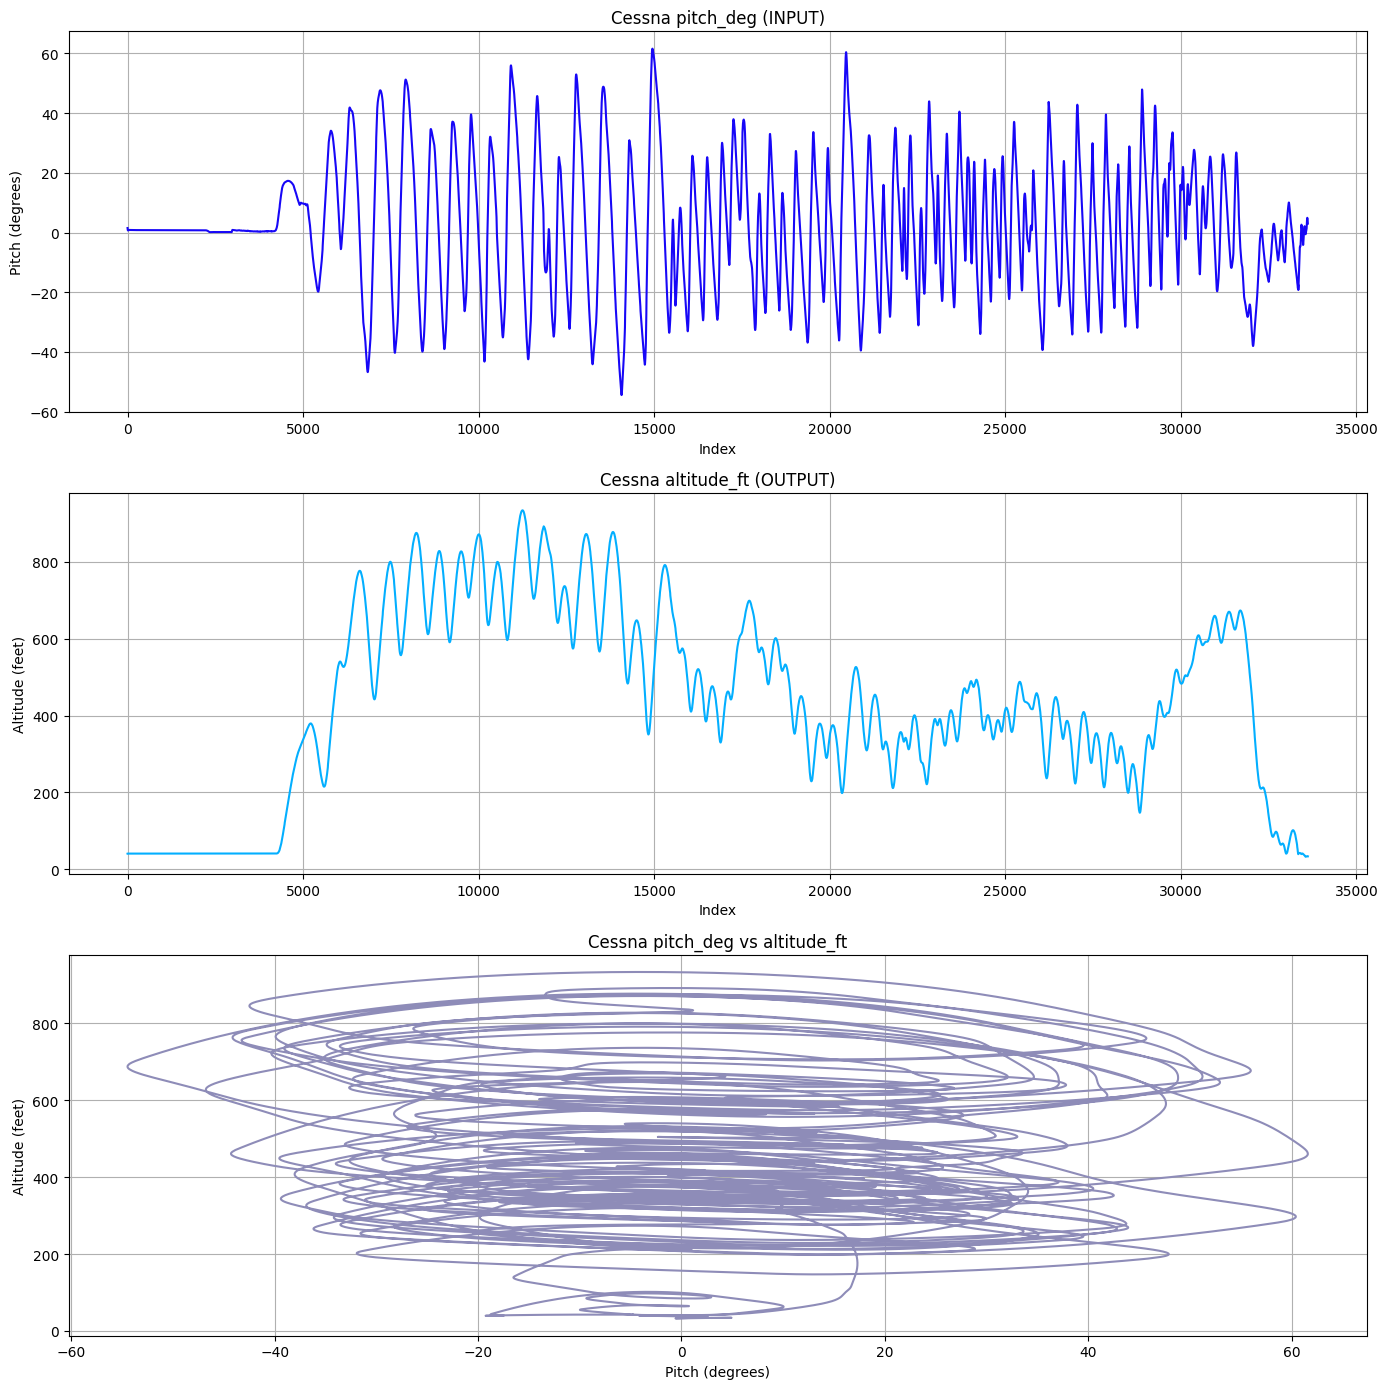

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(14,14))

axs[0].plot(df['x'], color='#1707f7')
axs[0].set_title('Cessna pitch_deg (INPUT)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Pitch (degrees)')
axs[0].grid(True)

axs[1].plot(df['y'], color='#03afff')
axs[1].set_title('Cessna altitude_ft (OUTPUT)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Altitude (feet)')
axs[1].grid(True)

axs[2].plot(df['x'], df['y'], color='#8e8cb8')
axs[2].set_title('Cessna pitch_deg vs altitude_ft')
axs[2].set_xlabel('Pitch (degrees)')
axs[2].set_ylabel('Altitude (feet)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# **EDA**

### **(1). STRUKTUR DATA**

In [5]:
print("Info Dataset")
print("Ukuran dataset lag:", df.shape, "\n")
df.info()

Info Dataset
Ukuran dataset lag: (33618, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33618 entries, 0 to 33617
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       33618 non-null  float64
 1   y       33618 non-null  float64
dtypes: float64(2)
memory usage: 525.4 KB


### **(2). CEK MISSING VALUES**

In [6]:
df.isna().sum()

x    0
y    0
dtype: int64

### **(3). CEK DUPLIKASI**

In [19]:
print(df[df.duplicated(keep=False)])
print(df.duplicated().sum(), "duplikat data ditemukan")

            x         y
92    0.81811  40.68186
98    0.81811  40.68186
149   0.81174  40.68213
156   0.81132  40.68215
157   0.81132  40.68215
...       ...       ...
2185  0.80485  40.68236
2427  0.14344  40.70242
2565  0.14259  40.70271
2566  0.14259  40.70271
2687  0.14344  40.70242

[968 rows x 2 columns]
588 duplikat data ditemukan


# **PRE-PROCESS DATA**

### **(1). MODEL DATA**

In [20]:
def lagged_dataset(df, cols, lag):
    df_new = pd.DataFrame()
    for col in cols:
        for i in range(lag+1):
            if i == 0:
                new_col_name = f'{col}(t)'
            else:
                new_col_name = f'{col}(t-{i})'

            # geser nilai kolom ke bawah sebanyak i
            df_new[new_col_name] = df[col].shift(i)
    
    # drop baris dengan nilai NaN
    df_new = df_new.dropna().reset_index(drop=True)

    return df_new

df_lag = lagged_dataset(df, cols=['x', 'y'], lag=4)
df_lag

,x(t),x(t-1),x(t-2),x(t-3),x(t-4),y(t),y(t-1),y(t-2),y(t-3),y(t-4)
0,0.99866,1.09080,1.21016,1.33864,1.49593,40.66761,40.65407,40.63076,40.59549,40.52764
1,0.91885,0.99866,1.09080,1.21016,1.33864,40.67645,40.66761,40.65407,40.63076,40.59549
2,0.85195,0.91885,0.99866,1.09080,1.21016,40.68192,40.67645,40.66761,40.65407,40.63076
3,0.81336,0.85195,0.91885,0.99866,1.09080,40.68441,40.68192,40.67645,40.66761,40.65407
4,0.77836,0.81336,0.85195,0.91885,0.99866,40.68620,40.68441,40.68192,40.67645,40.66761
...,...,...,...,...,...,...,...,...,...,...
33609,3.68583,3.86333,4.09472,4.23448,4.36476,33.79496,33.83958,33.89884,33.93513,33.96914
33610,3.50730,3.68583,3.86333,4.09472,4.23448,33.75129,33.79496,33.83958,33.89884,33.93513
33611,3.32268,3.50730,3.68583,3.86333,4.09472,33.70770,33.75129,33.79496,33.83958,33.89884
33612,3.15426,3.32268,3.50730,3.68583,3.86333,33.66908,33.70770,33.75129,33.79496,33.83958


### **(2). SPLIT DATA**

In [50]:
# ===== SPLIT DATA INPUT DAN TARGET =====
X1 = df_lag[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)', 'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)']].values
Y1 = df_lag[['y(t)']].values

print("Input (X) set shape  :", X1.shape)
print("Target (Y) set shape :", Y1.shape)

# ===== SPLIT DATA TRAINING, VALIDATION, TESTING =====
def splitdata(X, Y, train_size, val_size):
    total_size = X.shape[0]
    train_end = int(total_size * train_size)
    val_end = int(total_size * (train_size + val_size))

    X_train = X[:train_end]
    Y_train = Y[:train_end]

    X_val = X[train_end:val_end]
    Y_val = Y[train_end:val_end]

    X_test = X[val_end:]
    Y_test = Y[val_end:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X1_train, Y1_train, X1_val, Y1_val, X1_test, Y1_test = splitdata(X1, Y1, train_size=0.6, val_size=0.15)
print("\nTraining set shape   :", X1_train.shape, Y1_train.shape)
print("Validation set shape :", X1_val.shape, Y1_val.shape)
print("Testing set shape    :", X1_test.shape, Y1_test.shape)

Input (X) set shape  : (33614, 9)
Target (Y) set shape : (33614, 1)

Training set shape   : (20168, 9) (20168, 1)
Validation set shape : (5042, 9) (5042, 1)
Testing set shape    : (8404, 9) (8404, 1)


**visualisasi split data**

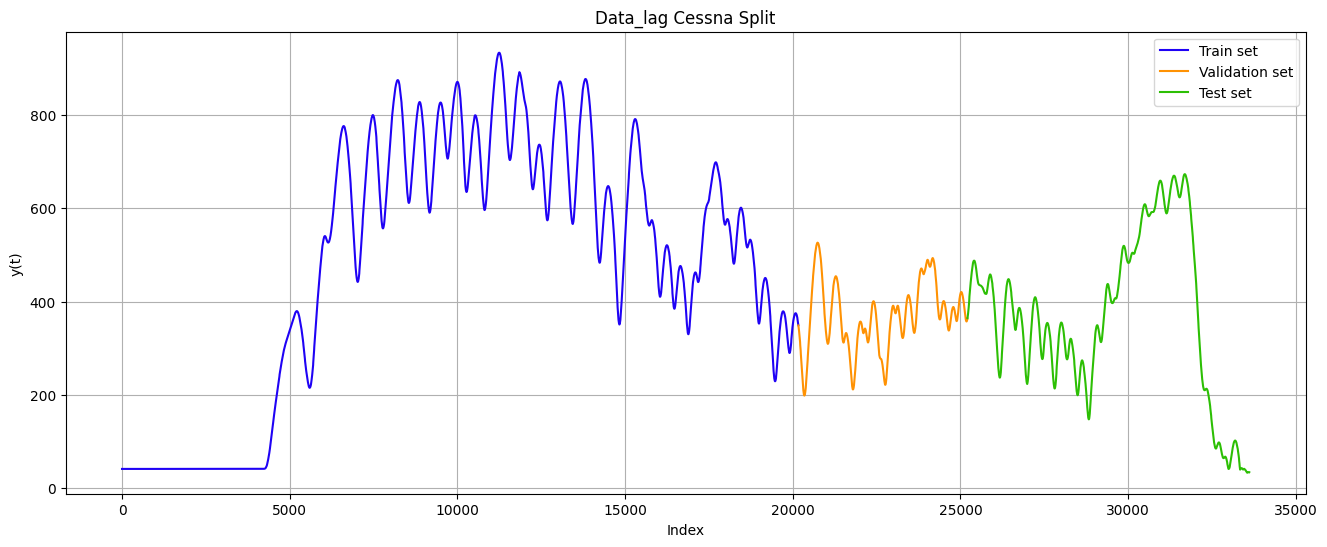

In [ ]:
fig, axs = plt.subplpts(2, 1, figsize=(16, 6))

idx_train = df_lag.index[:Y1_train.shape[0]]
idx_val = df_lag.index[Y1_train.shape[0]:Y1_train.shape[0]+Y1_val.shape[0]]
idx_test = df_lag.index[Y1_train.shape[0]+Y1_val.shape[0]:]

plt.plot(idx_train, Y1_train, label='Train set', color='#1f02f5')
plt.plot(idx_val, Y1_val, label='Validation set', color='#ff9203')
plt.plot(idx_test, Y1_test, label='Test set', color='#2cbf04')

plt.title('Data_lag Cessna Split')
plt.xlabel('Index')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()

### **(3). NORMALISASI DATA LAG**

In [63]:
# --- NORMALISASI (-1, 1) ---
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

# Fit training data
X1_train_norm = scaler_X.fit_transform(X1_train)
Y1_train_norm = scaler_Y.fit_transform(Y1_train)

# Transform validation and testing data
X1_val_norm = scaler_X.transform(X1_val)
Y1_val_norm = scaler_Y.transform(Y1_val)

X1_test_norm = scaler_X.transform(X1_test)
Y1_test_norm = scaler_Y.transform(Y1_test)

# --- CEK HASIL ---
print("Scaled Training  : ", X1_train_norm.shape, Y1_train_norm.shape)
print("Scaled Validation: ", X1_val_norm.shape, Y1_val_norm.shape)
print("Scaled Testing   : ", X1_test_norm.shape, Y1_test_norm.shape)

Scaled Training  :  (20168, 9) (20168, 1)
Scaled Validation:  (5042, 9) (5042, 1)
Scaled Testing   :  (8404, 9) (8404, 1)


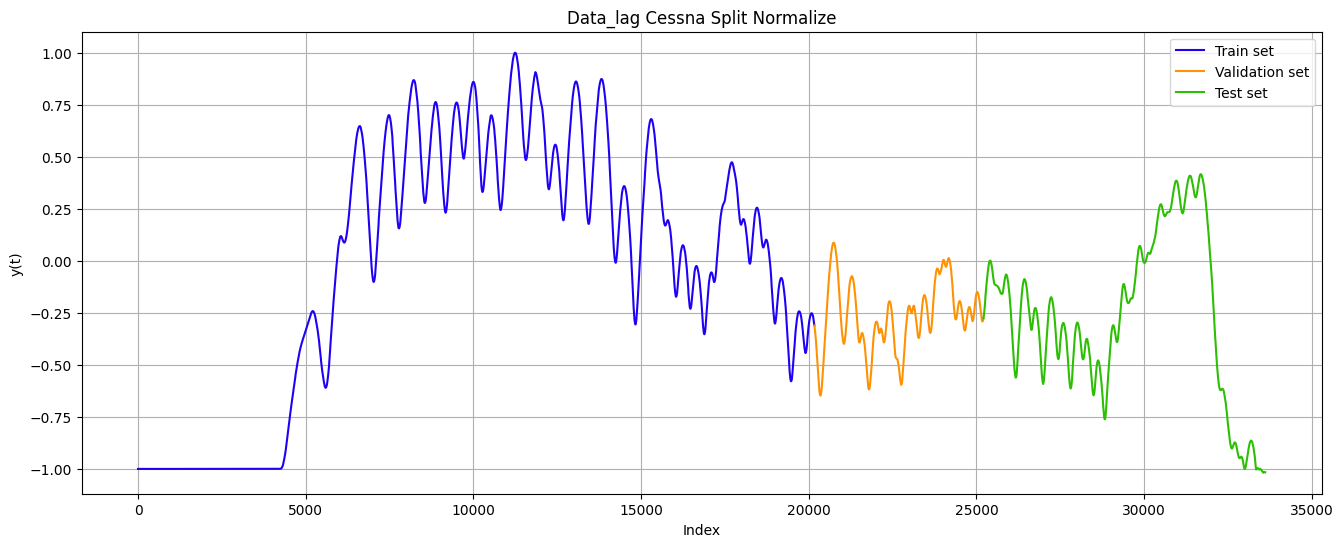

In [56]:
plt.figure(figsize=(16, 6))

plt.plot(idx_train, Y1_train_norm, label='Train set', color='#1f02f5')
plt.plot(idx_val, Y1_val_norm, label='Validation set', color='#ff9203')
plt.plot(idx_test, Y1_test_norm, label='Test set', color='#2cbf04')

plt.title('Data_lag Cessna Split Normalize')
plt.xlabel('Index')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()

# **SISTEM IDENTIFIKASI**

## **STAGE 1**

In [57]:
model = Sequential()
model.add(Dense(12, activation='tanh', input_dim=X1_train_norm.shape[1]))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mse')

model.summary()

c:\Users\Hanna\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233 (932.00 B)

 Trainable params: 233 (932.00 B)

 Non-trainable params: 0 (0.00 B)

### **(1). TRAINING-VALIDATION**

In [59]:
# Path to save best weight + model
best_weightsPath = "bestWeights_CESSNA.keras"

# Checkpoint to monitor errors
checkpoint = ModelCheckpoint(best_weightsPath, 
                             monitor='val_loss', # Monitor validation loss
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

# For early stopping
early_stopping_criteria = EarlyStopping(patience=15)

# List for callbacks
callbacks_list = [checkpoint, early_stopping_criteria]

# Training
history = model.fit(X1_train_norm, Y1_train_norm, 
                    epochs = 1000,
                    validation_data = (X1_val_norm, Y1_val_norm),
                    callbacks=callbacks_list)

model.save('final_model_CESSNNA.keras')

Epoch 1/1000
607/631 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0071
Epoch 1: val_loss improved from None to 0.00028, saving model to bestWeights_CESSNA.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021 - val_loss: 2.8336e-04
Epoch 2/1000
609/631 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.8109e-04
Epoch 2: val_loss improved from 0.00028 to 0.00028, saving model to bestWeights_CESSNA.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7226e-04 - val_loss: 2.7842e-04
Epoch 3/1000
608/631 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.4457e-04
Epoch 3: val_loss improved from 0.00028 to 0.00008, saving model to bestWeights_CESSNA.keras
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3718e-04 - val_loss: 7.6057e-05
Epoch 4/1000
630/631 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2351e-04
Epoch 4: val_loss did not improve from 0.00008
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1993e-04 - val_loss: 7.8989e-05
Epoch 5/1000
600/631 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

**plot loss train-val**

In [60]:
def get_model_info(model):
    layer_info = []
    
    for layer in model.layers:
        cfg = layer.get_config()
        name = layer.name
        activation = cfg.get("activation", "None")
        units = cfg.get("units", None)

        if units is not None:  # Hanya untuk Dense layer
            layer_info.append(f"{name}: units={units}, activation={activation}")
    
    # Untuk dijadikan nama file pendek: hanya hidden + aktivasi utama
    hidden_layers = [cfg.get("units") for cfg in (l.get_config() for l in model.layers) if cfg.get("units")]

    activations = [cfg.get("activation") for cfg in (l.get_config() for l in model.layers) if cfg.get("activation")]

    return layer_info, hidden_layers, activations


# Get model information
layer_info, hidden_layers, activations = get_model_info(model)

print("Layer Info:")
for info in layer_info:
    print(info)


Layer Info:
dense: units=12, activation=tanh
dense_1: units=8, activation=tanh
dense_2: units=1, activation=linear


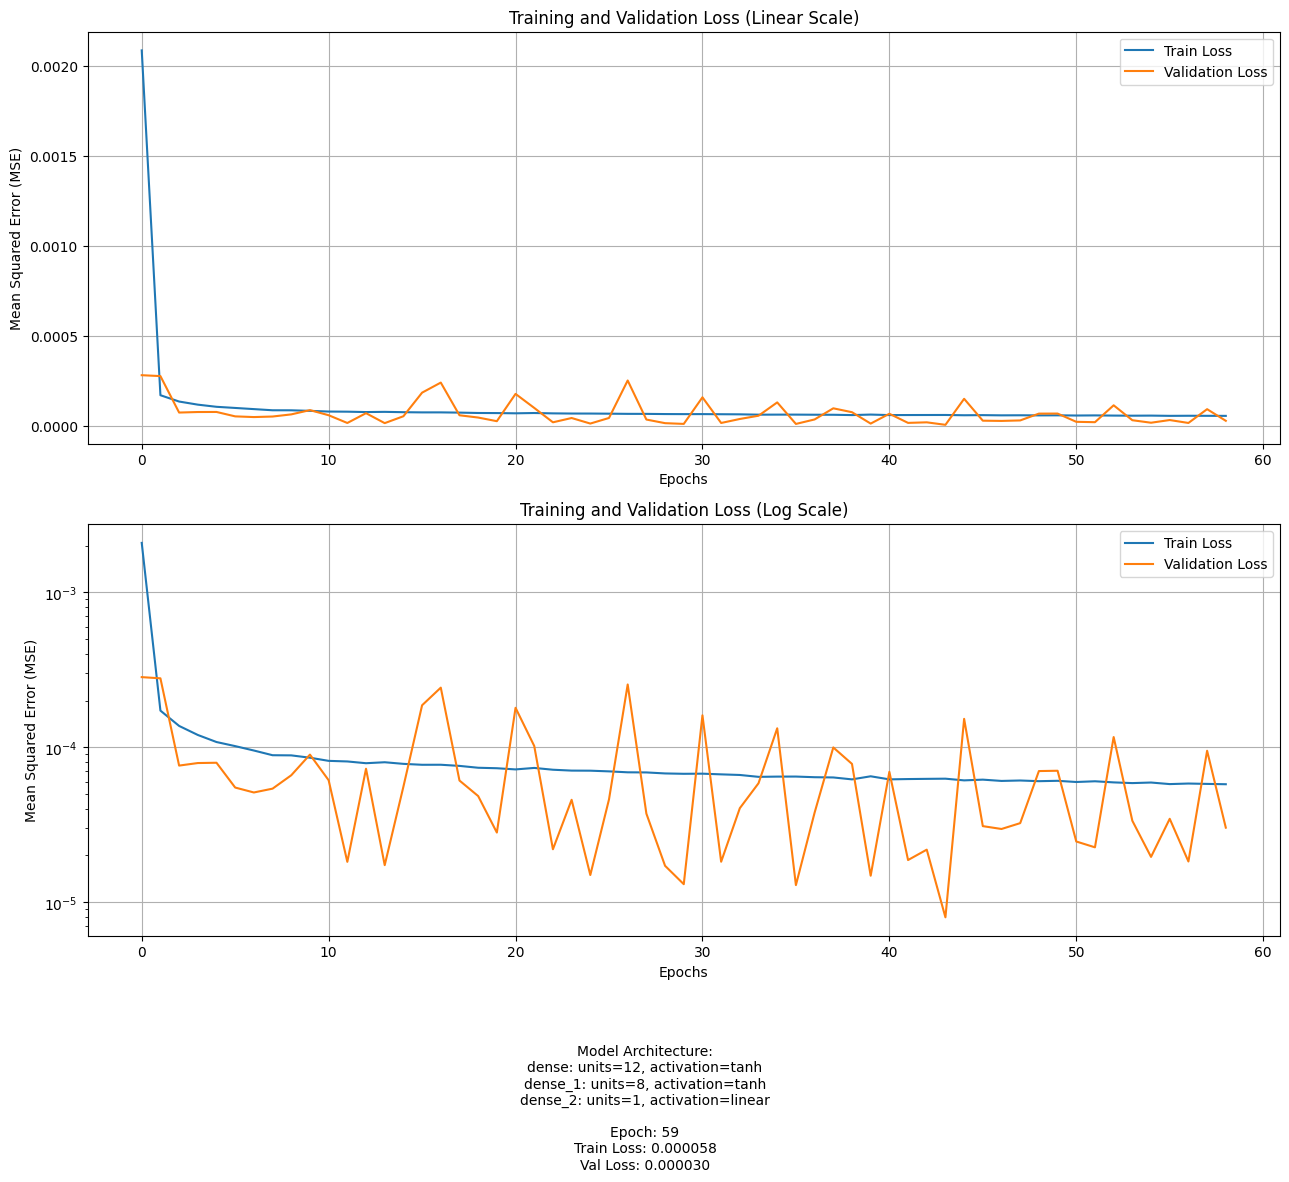

In [61]:
# info plot
train_losses = history.history["loss"]
val_losses = history.history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]

annotation_text = annotation_text = (
    "Model Architecture:\n" +
    "\n".join(layer_info) +
    f"\n\nEpoch: {last_epoch}"
    f"\nTrain Loss: {train_error:.6f}"
    f"\nVal Loss: {val_error:.6f}"
)

# plotting
fig, ax = plt.subplots(2, 1, figsize=(13, 10))

# ====== linear scale plot =====
ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_title('Training and Validation Loss (Linear Scale)')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].legend()
ax[0].grid(True)

# ===== log scale plot =====
ax[1].semilogy(train_losses, label='Train Loss')
ax[1].semilogy(val_losses, label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean Squared Error (MSE)')
ax[1].set_title('Training and Validation Loss (Log Scale)')
ax[1].grid(True)
ax[1].legend()

fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

### **(2). TESTING**

**MSE test**

In [62]:
test_loss = model.evaluate(X1_test_norm, Y1_test_norm)
print(f"Test Loss (MSE): {test_loss:.6f}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2923e-05
Test Loss (MSE): 0.000023


631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step


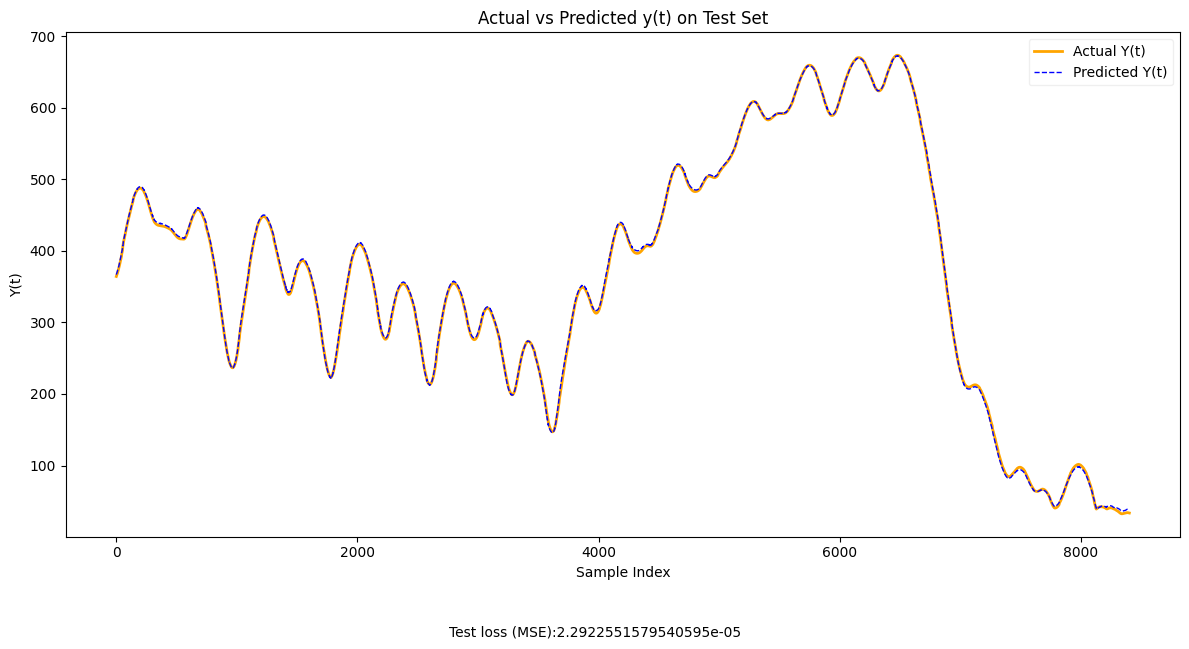

In [70]:
# prediksi train set
y_pred_train_norm = model.predict(X1_train_norm)
y_pred_train = scaler_Y.inverse_transform(y_pred_train_norm)
y_actual_train = Y1_train

# prediksi val set
y_pred_val_norm = model.predict(X1_val_norm)
y_pred_val = scaler_Y.inverse_transform(y_pred_val_norm)
y_actual_val = Y1_val

# prediksi test set
y_pred_test_norm = model.predict(X1_test_norm)
y_pred_test = scaler_Y.inverse_transform(y_pred_test_norm)
y_actual_test = Y1_test

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y_actual_test, label='Actual Y(t)', color='orange', linestyle='-', linewidth=2)
ax.plot(y_pred_test, label='Predicted Y(t)', color='blue', linestyle='--', linewidth=1) 
ax.set_title('Actual vs Predicted y(t) on Test Set')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Y(t)')
ax.legend(framealpha=0.3)
fig.text(0.5, -0.05, 
         f"Test loss (MSE):" + str(test_loss),
         ha='center', va='top')

plt.tight_layout()
plt.show()

# **STAGE 2**

### **(1). DATA**

In [71]:
# load model stage 1
model_stage1 = load_model('final_model_CESSNNA.keras')

n_samples = len(df_lag)

X1_all = df_lag[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)', 
                 'y(t-1)', 'y(t-2)', 'y(t-3)', 'y(t-4)']].values
X1_all_norm = scaler_X.transform(X1_all)

y1_all_pred_norm = model_stage1.predict(X1_all_norm)
y1_all_pred = scaler_Y.inverse_transform(y1_all_pred_norm)

# simpan ke df_lag untuk lag prediksi
df_lag['y1_pred(t)'] = y1_all_pred
df_lag['y1_pred(t-1)'] = df_lag['y1_pred(t)'].shift(1)
df_lag['y1_pred(t-2)'] = df_lag['y1_pred(t)'].shift(2)
df_lag['y1_pred(t-3)'] = df_lag['y1_pred(t)'].shift(3)
df_lag['y1_pred(t-4)'] = df_lag['y1_pred(t)'].shift(4)
df_lag = df_lag.dropna().reset_index(drop=True)

# data untuk stage 2
X2 = df_lag[['x(t)', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'x(t-4)', 
             'y1_pred(t-1)', 'y1_pred(t-2)', 'y1_pred(t-3)', 'y1_pred(t-4)']].values
Y2 = df_lag[['y(t)']].values

print("Input (X2) set shape  :", X2.shape)
print("Target (Y2) set shape :", Y2.shape)

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Input (X2) set shape  : (33610, 9)
Target (Y2) set shape : (33610, 1)


### **(2). SPLIT DATA**

In [72]:
N = len(X2)

X2_train, Y2_train, X2_val, Y2_val, X2_test, Y2_test = splitdata(X2, Y2, train_size=0.6, val_size=0.15)

print("Train shape  :", X2_train.shape, Y2_train.shape)
print("Val shape    :", X2_val.shape, Y2_val.shape)
print("Test shape   :", X2_test.shape, Y2_test.shape)

Train shape  : (20166, 9) (20166, 1)
Val shape    : (5041, 9) (5041, 1)
Test shape   : (8403, 9) (8403, 1)


### **(3). NORMALISASI**

In [73]:
scaler_X2 = MinMaxScaler(feature_range=(-1, 1))
scaler_Y2 = MinMaxScaler(feature_range=(-1, 1))

X2_train_norm = scaler_X2.fit_transform(X2_train)
Y2_train_norm = scaler_Y2.fit_transform(Y2_train)
X2_val_norm = scaler_X2.transform(X2_val)
Y2_val_norm = scaler_Y2.transform(Y2_val)
X2_test_norm = scaler_X2.transform(X2_test)
Y2_test_norm = scaler_Y2.transform(Y2_test)

X2_train_norm = X2_train_norm.astype(np.float32)
Y2_train_norm = Y2_train_norm.astype(np.float32)
X2_val_norm = X2_val_norm.astype(np.float32)
Y2_val_norm = Y2_val_norm.astype(np.float32)
X2_test_norm = X2_test_norm.astype(np.float32)
Y2_test_norm = Y2_test_norm.astype(np.float32)

print("Scaled Train  : ", X2_train_norm.shape, Y2_train_norm.shape)
print("Scaled Val    : ", X2_val_norm.shape, Y2_val_norm.shape)
print("Scaled Test   : ", X2_test_norm.shape, Y2_test_norm.shape)

Scaled Train  :  (20166, 9) (20166, 1)
Scaled Val    :  (5041, 9) (5041, 1)
Scaled Test   :  (8403, 9) (8403, 1)


### **(4). MODEL MLP STAGE 2***

In [74]:
def build_stage2(input_dim):
    model = Sequential()
    model.add(tf.keras.Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error')
    return model

model2 = build_stage2(X2_train_norm.shape[1])
optimizer = tf.keras.optimizers.Adam(1e-3)

### **(5). TRAINING-VALIDATION (CUSTOM LOOP)**

In [75]:
# ============ Training Step ==============
@tf.function
def train_step(xi, yi):
    with tf.GradientTape() as tape:
        y_pred = model2(xi, training=True)
        loss = tf.reduce_mean((yi - y_pred)**2)
    grads = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(grads, model2.trainable_variables))
    return loss


# ============ Training Loop ==============
train_losses = []
val_losses = []

epochs = 100

for epoch in range(epochs):

    # ==== TRAINING PER-SAMPLE ====
    epoch_loss = 0.0
    for i in range(len(X2_train_norm)):
        xi = X2_train_norm[i:i+1]
        yi = Y2_train_norm[i:i+1]
        loss = train_step(xi, yi)
        epoch_loss += loss.numpy()

    epoch_loss /= len(X2_train_norm)
    train_losses.append(epoch_loss)

    # ==== VALIDATION ====
    y_val_pred = model2.predict(X2_val_norm, verbose=0)
    val_loss = np.mean((Y2_val_norm - y_val_pred)**2)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}  TrainLoss={epoch_loss}  ValLoss={val_loss}")


Epoch 1/100  TrainLoss=0.0033973006065934896  ValLoss=0.9517441391944885
Epoch 2/100  TrainLoss=0.00042613508412614465  ValLoss=2.238779067993164
Epoch 3/100  TrainLoss=0.01468176394701004  ValLoss=0.22683097422122955
Epoch 4/100  TrainLoss=0.0009505837224423885  ValLoss=6.105922698974609
Epoch 5/100  TrainLoss=0.005032225511968136  ValLoss=0.849629819393158
Epoch 6/100  TrainLoss=0.0003189152048435062  ValLoss=5.113993167877197
Epoch 7/100  TrainLoss=0.0028937903698533773  ValLoss=1.6525222063064575
Epoch 8/100  TrainLoss=0.0008544173906557262  ValLoss=0.20605388283729553
Epoch 9/100  TrainLoss=0.000525075476616621  ValLoss=0.6830660700798035
Epoch 10/100  TrainLoss=0.0019244536524638534  ValLoss=0.17870664596557617
Epoch 11/100  TrainLoss=0.0003822408907581121  ValLoss=0.09848668426275253
Epoch 12/100  TrainLoss=0.0007132271421141922  ValLoss=0.1809217482805252
Epoch 13/100  TrainLoss=0.0012168079847469926  ValLoss=0.44690439105033875
Epoch 14/100  TrainLoss=0.0020017444621771574  Va

**plot loss train dan val**

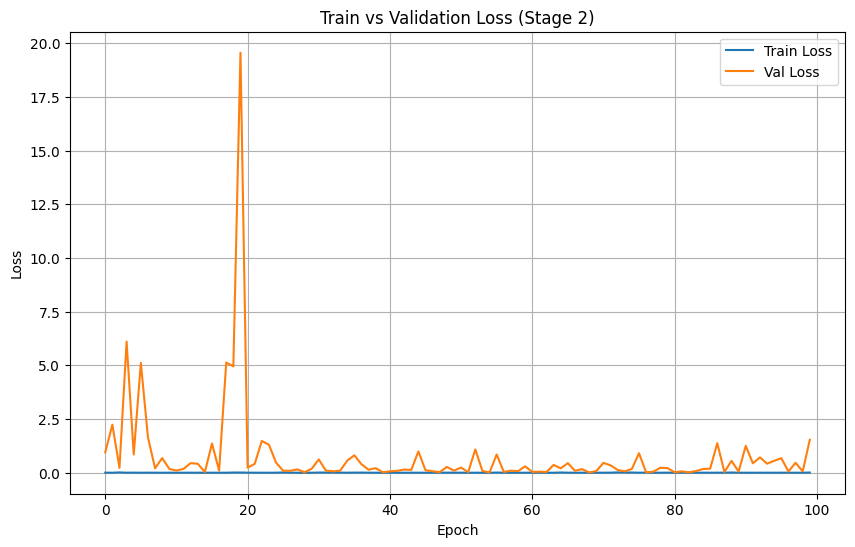

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (Stage 2)')
plt.legend()
plt.grid(True)
plt.show()

### **(6). TESTING**

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


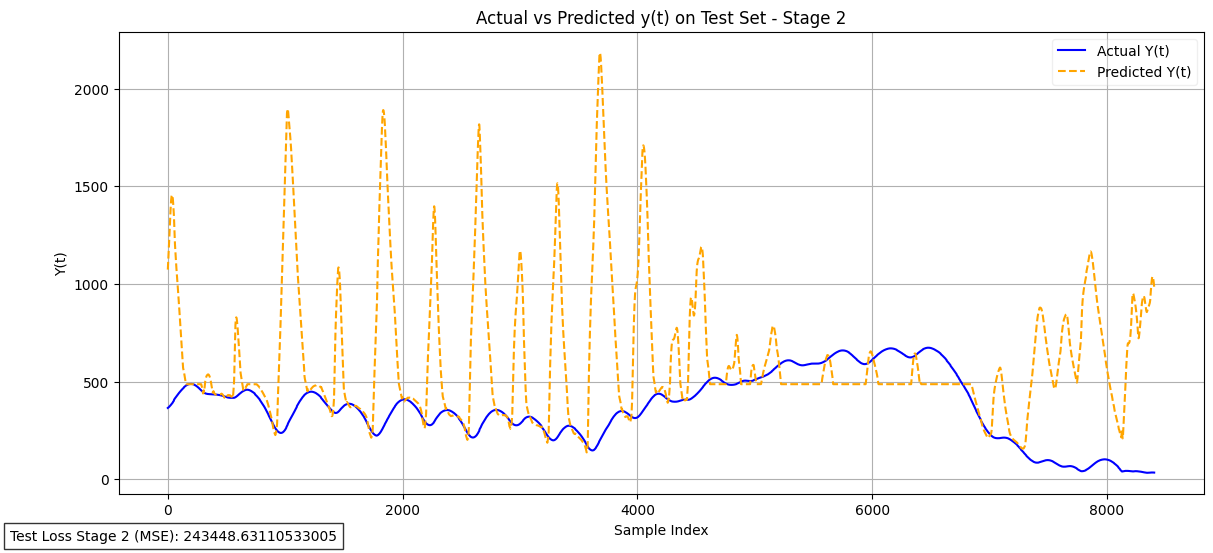

In [77]:
y2_test_pred_norm = model2.predict(X2_test_norm)
y2_test_pred = scaler_Y2.inverse_transform(y2_test_pred_norm)
y2_test_actual = Y2_test

test_loss2 = np.mean((Y2_test - y2_test_pred)**2)

# plotting
plt.figure(figsize=(14, 6))
plt.plot(y2_test_actual, label='Actual Y(t)', color='blue')
plt.plot(y2_test_pred, label='Predicted Y(t)', color='orange', linestyle='--')
plt.title('Actual vs Predicted y(t) on Test Set - Stage 2')
plt.xlabel('Sample Index')
plt.ylabel('Y(t)')
plt.legend(framealpha=0.3)
plt.text(
    -0.10, -0.10,             # posisi relatif plot
    f"Test Loss Stage 2 (MSE): {test_loss2}",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.grid(True)
plt.show()